Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
11493376/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7053  g_loss:0.6912
epoch:1  d_loss:0.4624  g_loss:0.3282
epoch:2  d_loss:0.5685  g_loss:0.1025
epoch:3  d_loss:0.6585  g_loss:0.0836
epoch:4  d_loss:0.5767  g_loss:0.1651
epoch:5  d_loss:0.5087  g_loss:0.4210
epoch:6  d_loss:0.4876  g_loss:0.6971
epoch:7  d_loss:0.5093  g_loss:0.8695
epoch:8 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


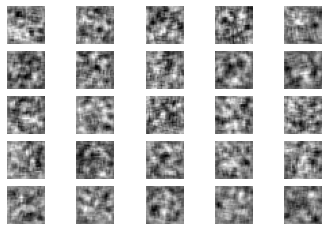

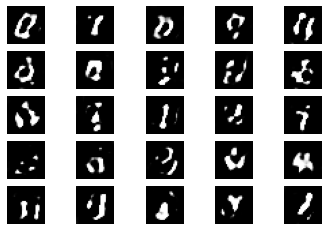

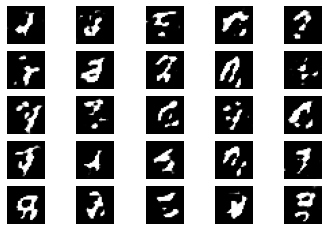

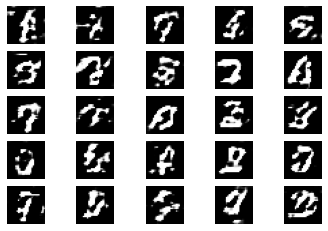

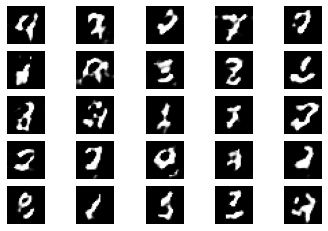

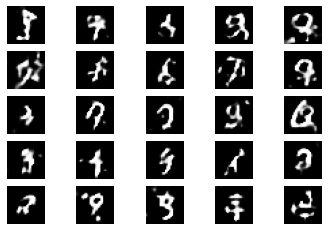

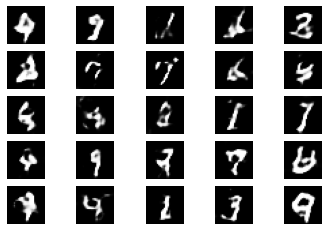

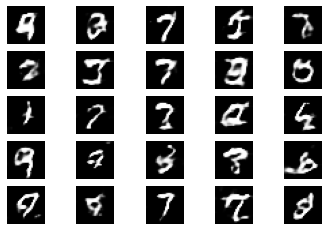

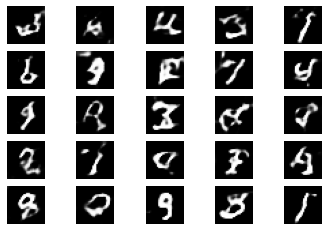

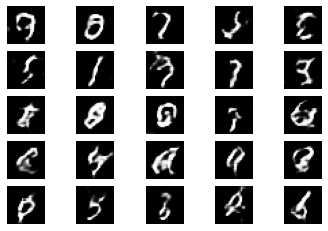

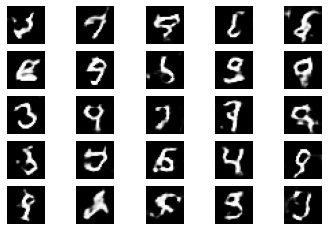

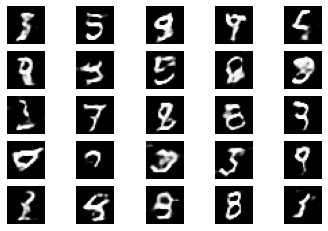

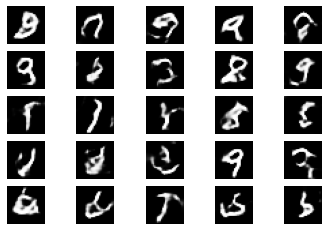

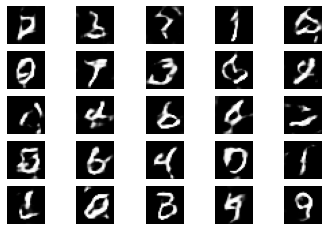

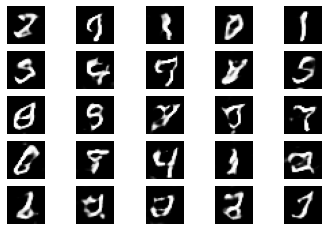

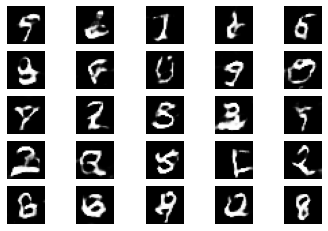

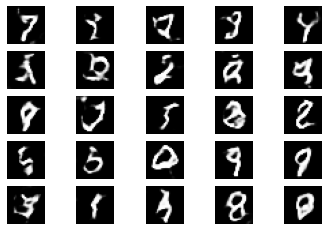

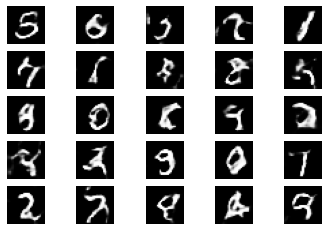

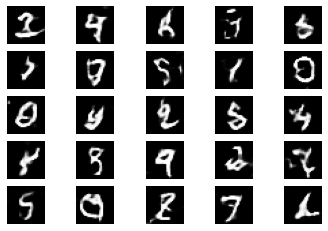

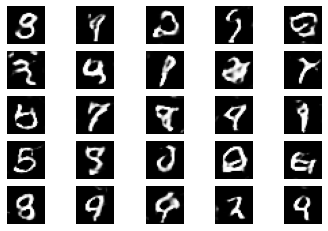

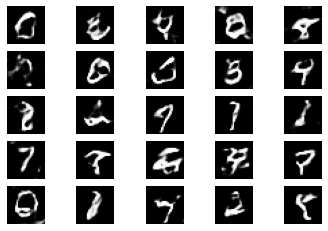

In [1]:
#-*- coding: utf-8 -*-

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")
#동일한 결과가 나오기 위해서.
np.random.seed(3)
tf.random.set_seed(3)

#생성자 모델을 만듭니다.
generator = Sequential()
#128은 임의의(뉴런) 노드수, 7*7은 이미지 사이즈*(mnist이미지= 28*28), 인풋은 100개(임의지정) 벡터,
#활성화 함수는 leakyReLu 얘는 relu랑 다르게 음수여도 0에 가까운 값을 보냄
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
#정규화(batch단위로)
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
#upsampling2d : 이미지 사이즈를 2배로 만들어줌 7*7 >> 14*14
generator.add(UpSampling2D())

#노드수 64, kernel_size=5 (5*5 사이즈) padding = same 원 이미지 크기랑 동일하게 맞춰줌 채울때0을채움
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())

#출력층 노드수 1 , 활성화함수는 탄젠트 사용 -1~1까지 맞춰주기 위해서.
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))


#tanh 함수는 함수의 중심값을 0으로 옮겨 sigmoid의 최적화 과정이 느려지는 문제를 해결
#하지만 미분함수에 대해 일정값 이상 커질시 미분값이 소실되는
#gradient vanishing 문제는 여전히 남아있다.


#판별자 모델을 만듭니다.
discriminator = Sequential()

#strides=2 이건 2칸씩 커널이 움직인다는말 
#input_shape(28,28,1)28*28이미지 사이즈 , 1(흑백, 3:RGB)
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
#0.3(30%를 랜덤하게 날림) 과적화 방지
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

#2차원 이미지르 1차원 배열로 Flatten()
discriminator.add(Flatten())

#이진분류라 시그모이드(참,거짓 반환)
discriminator.add(Dense(1, activation='sigmoid'))

#이진분류 손실함수 binary_crossentropy 사용
#최적화는 아담. 
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

#판별자는 가중치를 적용하지(학습) 않음(학습하면 안됨)!
discriminator.trainable = False




#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
#랜덤으로 100개의 벡터. 생성자에 인풋값으로 넣음 generator(ginput)

ginput = Input(shape=(100,))

#생성자를 통과한 값을 판별자에 넣음. 그 결과값을 dis_output에 넣음(결과값 도출)
dis_output = discriminator(generator(ginput))

#판별자를 통과한 결과값 과 실제값이 동일한지 판별
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()



#신경망을 실행시키는 함수를 만듭니다.
# test data 가 필요 없음. 훈련용 데이터가 곧 원본 데이터
def gan_train(epoch, batch_size, saving_interval):



# MNIST 데이터 불러오기
# 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 
#단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  (X_train, _), (_, _) = mnist.load_data() 
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
# 픽셀값은 0에서 255사이의 값입니다. 
#이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 
#여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값(tanh)으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape
  X_train = (X_train - 127.5) / 127.5  

  true = np.ones((batch_size, 1))   # .ones = True (True:1)
  fake = np.zeros((batch_size, 1))  # .zeros=True  (False:0) 
#모두 참, 모두 거짓 배열을 각각 true, fake로 만듦


  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          #실제 이미지
          imgs = X_train[idx]
          #실제 데이터를 판별
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
          #random.normal(정규분포) 평균이 0이고 분산이 1
          noise = np.random.normal(0, 1, (batch_size, 100))
          #생성자를 이용해 노이즈로 만들어주는 예측값(만든 이미지)
          gen_imgs = generator.predict(noise)
          #만들어진 데이터를 판별
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          #진짜값과 가짜값을 더해평균을냄
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  
#4000번 반복되고(+1을 해 주는 것에 주의), 
#배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.
